In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
            
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from keras.layers.merge import concatenate
from keras.layers import Input
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import MaxPooling2D, Flatten,Conv2D, Dense,BatchNormalization,GlobalAveragePooling2D,Dropout, Flatten
from tensorflow.keras.applications.densenet import DenseNet169
%matplotlib inline

In [3]:
!ls ../input/data/

ARXIV_V5_CHESTXRAY.pdf	README_CHESTXRAY.pdf  images_005  images_010
BBox_List_2017.csv	images_001	      images_006  images_011
Data_Entry_2017.csv	images_002	      images_007  images_012
FAQ_CHESTXRAY.pdf	images_003	      images_008  test_list.txt
LOG_CHESTXRAY.pdf	images_004	      images_009  train_val_list.txt


In [4]:
# images_001 range(00000001_000.png to 00001335_006.png)
# images_002 range(00001336_000.png to 00003923_013.png)
# images_003 range(00003923_014.png to 00006585_006.png)
# images_004 range(00006585_007.png to 00009232_003.png)
# images_005 range(00009232_004.png to 00011558_007.png)
# images_006 range(00011558_008.png to 00013774_025.png)
# images_007 range(00013774_026.png to 00016051_009.png)
# images_008 range(00016051_010.png to 00018387_034.png)
# images_009 range(00018387_035.png to 00020945_049.png)
# images_010 range(00020945_050.png to 00024717_000.png)
# images_011 range(00024718_000.png to 00030805_000.png)
# images_012 range()

# create a dictionary of all the subdirectories
images_dic = {
              'images_001':[],
              'images_002':[],
              'images_003':[],
              'images_004':[],
              'images_005':[],
              'images_006':[],
              'images_007':[],
              'images_008':[],
              'images_009':[],
              'images_010':[],
              'images_011':[],
              'images_012':[]
             }

for subdir in images_dic.keys():
    for path, subdirs, files in os.walk(f'../input/data/{subdir}/images/'):
        for filename in files:
            images_dic[subdir].append(filename)
            


In [5]:
# view that all the keys and images were listed
images_dic_lengths = [(key, len(images_dic[key])) for key in images_dic.keys()]
images_dic_lengths

[('images_001', 4999),
 ('images_002', 10000),
 ('images_003', 10000),
 ('images_004', 10000),
 ('images_005', 10000),
 ('images_006', 10000),
 ('images_007', 10000),
 ('images_008', 10000),
 ('images_009', 10000),
 ('images_010', 10000),
 ('images_011', 10000),
 ('images_012', 7121)]

## Import the Meta Data into Dataframes

In [6]:
#import the meta-data for the images
data_entry_df = pd.read_csv('../input/data/Data_Entry_2017.csv')
data_entry_df.drop(columns=['Unnamed: 11'], inplace=True)
data_entry_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143


In [7]:
# training data
training_data = []
with open('../input/data/train_val_list.txt') as mytext:
    for line in mytext:
        training_data.append(line.rstrip())

In [8]:
# test data
testing_data = []
with open('../input/data/test_list.txt') as mytext:
    for line in mytext:
        testing_data.append(line.rstrip())

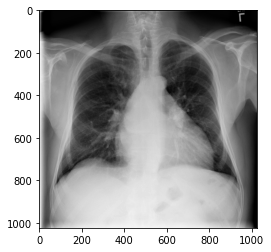

In [9]:
import matplotlib.image as mpimage

ex1_data = mpimage.imread('../input/data/images_001/images/00000001_000.png')
imgplot = plt.imshow(ex1_data, cmap='gray')


In [10]:
# create a function that returns the full image path
def full_img_path(file_name, img_dic=images_dic):
    '''
        The function takes in the .png file name and the dictionary of all images
        Then finds the subdirectory name with that images in its list
        Returns the full path in a string format
    '''
    try:
        for key in img_dic.keys():
            if file_name in img_dic[key]:
                full_path = f'../input/data/{key}/images/{file_name}'
                return full_path
    except:
        return None

In [11]:
# create a new dataframe for the image path and get the full path and store it
image_path_df = data_entry_df[['Image Index']]
image_path_df['path'] = image_path_df['Image Index'].apply(full_img_path)
image_path_df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Image Index,path
0,00000001_000.png,../input/data/images_001/images/00000001_000.png
1,00000001_001.png,../input/data/images_001/images/00000001_001.png
2,00000001_002.png,../input/data/images_001/images/00000001_002.png
3,00000002_000.png,../input/data/images_001/images/00000002_000.png
4,00000003_000.png,../input/data/images_001/images/00000003_000.png


In [12]:
# store a csv file for easier access later
image_path_df.to_csv('image_path.csv')

In [13]:
!ls ../input/data

ARXIV_V5_CHESTXRAY.pdf	README_CHESTXRAY.pdf  images_005  images_010
BBox_List_2017.csv	images_001	      images_006  images_011
Data_Entry_2017.csv	images_002	      images_007  images_012
FAQ_CHESTXRAY.pdf	images_003	      images_008  test_list.txt
LOG_CHESTXRAY.pdf	images_004	      images_009  train_val_list.txt


In [14]:
test_df = pd.read_csv('image_path.csv', index_col=[0])
test_df.head()

,Image Index,path
0,00000001_000.png,../input/data/images_001/images/00000001_000.png
1,00000001_001.png,../input/data/images_001/images/00000001_001.png
2,00000001_002.png,../input/data/images_001/images/00000001_002.png
3,00000002_000.png,../input/data/images_001/images/00000002_000.png
4,00000003_000.png,../input/data/images_001/images/00000003_000.png


In [15]:
image_path_df.isna().sum()


Image Index    0
path           0
dtype: int64

### Combine the image_path_df with the data_entry_df

In [16]:
data_entry_df = pd.merge(data_entry_df, image_path_df, how="inner", on='Image Index')
data_entry_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,../input/data/images_001/images/00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,../input/data/images_001/images/00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,../input/data/images_001/images/00000001_002.png
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,../input/data/images_001/images/00000002_000.png
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,../input/data/images_001/images/00000003_000.png


## View an X-ray Image

In [17]:
# create a function to load images
def load_image(file_name):
    '''
        The function takes in .png file name
        Then checks all the image directories for the file
        Returns the image data as an matrix of pixel values
    '''
    for n1 in range(2):
        for n2 in range(1, 10):
            image_dir = f'../input/data/images_0{n1}{n2}/images/'
            if os.path.isfile(image_dir+file_name):
                image_data = mpimage.imread(image_dir+file_name)
    return image_data

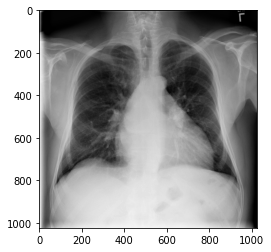

In [18]:
# view one of the xrays
image_1 = load_image(data_entry_df.loc[0, 'Image Index'])
plt.imshow(image_1, cmap='gray')

## Create dataframes for testing and training

In [19]:
train_df = data_entry_df[data_entry_df['Image Index'].isin(training_data)]
test_df = data_entry_df[data_entry_df['Image Index'].isin(testing_data)]

In [20]:
train_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,../input/data/images_001/images/00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,../input/data/images_001/images/00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,../input/data/images_001/images/00000001_002.png
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,../input/data/images_001/images/00000002_000.png
12,00000004_000.png,Mass|Nodule,0,4,82,M,AP,2500,2048,0.168,0.168,../input/data/images_001/images/00000004_000.png


In [21]:
test_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,../input/data/images_001/images/00000003_000.png
5,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,0.168,../input/data/images_001/images/00000003_001.png
6,00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,0.168,0.168,../input/data/images_001/images/00000003_002.png
7,00000003_003.png,Hernia|Infiltration,3,3,76,F,PA,2698,2991,0.143,0.143,../input/data/images_001/images/00000003_003.png
8,00000003_004.png,Hernia,4,3,77,F,PA,2500,2048,0.168,0.168,../input/data/images_001/images/00000003_004.png


In [22]:
# split the finding labels 
train_labels = train_df['Finding Labels'].str.split('|')
test_labels = test_df['Finding Labels'].str.split('|')

In [23]:
train_df['Finding Labels'] = train_labels
train_df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path
0,00000001_000.png,[Cardiomegaly],0,1,58,M,PA,2682,2749,0.143,0.143,../input/data/images_001/images/00000001_000.png
1,00000001_001.png,"[Cardiomegaly, Emphysema]",1,1,58,M,PA,2894,2729,0.143,0.143,../input/data/images_001/images/00000001_001.png
2,00000001_002.png,"[Cardiomegaly, Effusion]",2,1,58,M,PA,2500,2048,0.168,0.168,../input/data/images_001/images/00000001_002.png
3,00000002_000.png,[No Finding],0,2,81,M,PA,2500,2048,0.171,0.171,../input/data/images_001/images/00000002_000.png
12,00000004_000.png,"[Mass, Nodule]",0,4,82,M,AP,2500,2048,0.168,0.168,../input/data/images_001/images/00000004_000.png


In [24]:
test_df['Finding Labels'] = test_labels
test_df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path
4,00000003_000.png,[Hernia],0,3,81,F,PA,2582,2991,0.143,0.143,../input/data/images_001/images/00000003_000.png
5,00000003_001.png,[Hernia],1,3,74,F,PA,2500,2048,0.168,0.168,../input/data/images_001/images/00000003_001.png
6,00000003_002.png,[Hernia],2,3,75,F,PA,2048,2500,0.168,0.168,../input/data/images_001/images/00000003_002.png
7,00000003_003.png,"[Hernia, Infiltration]",3,3,76,F,PA,2698,2991,0.143,0.143,../input/data/images_001/images/00000003_003.png
8,00000003_004.png,[Hernia],4,3,77,F,PA,2500,2048,0.168,0.168,../input/data/images_001/images/00000003_004.png


In [25]:
diseases = []
for disease in train_labels:
    for val in range(len(disease)):
        if disease[val] not in diseases:
            diseases.append(disease[val])

In [26]:
diseases

['Cardiomegaly',
 'Emphysema',
 'Effusion',
 'No Finding',
 'Mass',
 'Nodule',
 'Infiltration',
 'Atelectasis',
 'Pleural_Thickening',
 'Fibrosis',
 'Consolidation',
 'Pneumonia',
 'Edema',
 'Pneumothorax',
 'Hernia']

## View the Distribution of Diseases

In [44]:
train_disease_dict = {}
count = 0

for disease in diseases:
    for idx, row in train_df.iterrows():
        if disease in train_df.loc[idx, 'Finding Labels']:
            count += 1 
    train_disease_dict[disease] = count

In [59]:
train_disease_df = pd.DataFrame.from_dict(train_disease_dict, orient='index', columns=['Count'])
train_disease_df

,Count
Cardiomegaly,1707
Emphysema,3130
Effusion,11789
No Finding,62289
Mass,66323
Nodule,71031
Infiltration,84813
Atelectasis,93093
Pleural_Thickening,95335
Fibrosis,96586


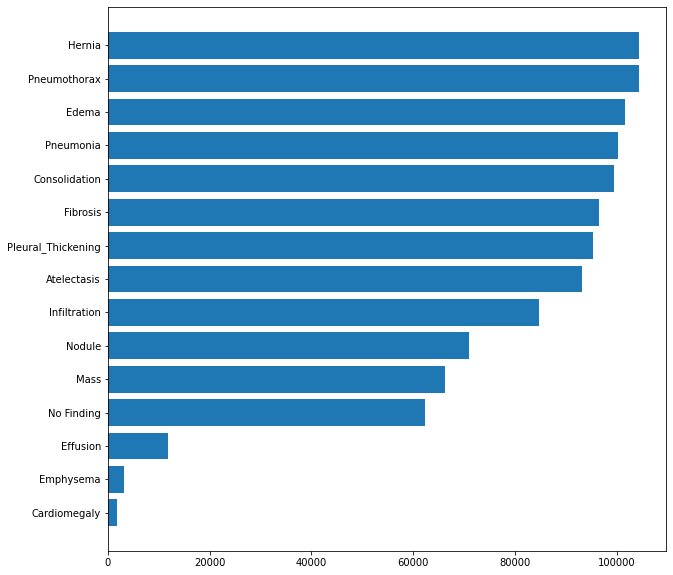

In [61]:
plt.figure(figsize=(10, 10))
plt.barh(train_disease_df.index, train_disease_df['Count'])
plt.show()

In [62]:
# view the values sorted
train_disease_df.sort_values(by=['Count'], ascending=True)

,Count
Cardiomegaly,1707
Emphysema,3130
Effusion,11789
No Finding,62289
Mass,66323
Nodule,71031
Infiltration,84813
Atelectasis,93093
Pleural_Thickening,95335
Fibrosis,96586


### Analysis of the Disease Distribution:

There is a large difference between the most frequent diseases and the least frequent diseases. Hernia has almost two orders of magnitude more that the least frequent disease Cardiomegaly.

Since this is an image classification model, in which training is resource expense, the least frequent disease will roughly set the count for all other diseases, though pneumonia will be expected to be present in roughly half of the training set.

In [ ]:
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [ ]:
train_df.head(10)

## Create a Pneumonia Column for Classification

In [ ]:
train_df['Pneumonia'] = [0]*train_df.shape[0]

In [ ]:
# iterate through the rows and assign 1 to Pneumonia if it is present in Finding Labels


for idx, row in train_df.iterrows():
    if 'Pneumonia' in row['Finding Labels']:
        train_df.loc[idx, 'Pneumonia'] = 1

In [ ]:
train_df['Pneumonia'].value_counts()

### The Pneumonia X-ray images are significantly under represented

This will likely cause the model to be unable to learn pneumonia due to the skewed dataset. In order to increase their prevalence for training this binary classifier, the number of pneumonia images will be increased by 10x while the number of non-pneumonia images will be decreased by 10x. Since data augmentation will be applied, the model will not be seeing each pneumonia image 10 times, but will instead be seeing the image augmented in different ways each time. This means that the image is giving some variety. But the ultimate test of whether this pneumonia duplication creates overfitting will be exposed in the test set. 

In [ ]:
train_pneumonia = train_df[train_df['Pneumonia'] == 1]

train_pneumonia['Pneumonia'].value_counts()

In [ ]:
# copy the training pneumonia data 10x
train_pneumonia = pd.concat([train_pneumonia, 
                             train_pneumonia, 
                             train_pneumonia,
                            train_pneumonia,
                            train_pneumonia], axis=0).reset_index(drop=True)
train_pneumonia = pd.concat([train_pneumonia, train_pneumonia], axis=0).reset_index(drop=True)
train_pneumonia.shape

In [ ]:
# decrease the training no pneumonia data by 10x
train_no_pneumonia = train_df[train_df['Pneumonia'] == 0].sample(frac=0.1)
train_no_pneumonia.shape

### Concatenate the two training dataframes together and shuffle

In [ ]:
train_df = pd.concat([train_pneumonia, train_no_pneumonia], axis=0).sample(frac=1.0).reset_index(drop=True)
train_df['Pneumonia'].value_counts()

## Create a Pneumonia Column for the Test Data

In [ ]:
test_df['Pneumonia'] = [0]*test_df.shape[0]

In [ ]:
# iterate through the rows and assign 1 if Pneumonia is present
for idx, row in test_df.iterrows():
    if 'Pneumonia' in test_df.loc[idx, 'Finding Labels']:
        test_df.loc[idx, 'Pneumonia'] = 1

In [ ]:
test_df['Pneumonia'].value_counts()

## Image Generators and Augmentation

In [ ]:
def create_splits(df):
    ''' 
        The input is a dataframe
        The function will have two outputs a training dataframe and a validation dataframe
        This function will focus on splitting with a balanced set of pneumonia and non-pneumonia for the training set
        Validation dataset will not have any requirements for balanced data
    '''
    
    # create a split of pneumonia and non-pneumonia
    pneum = df[df['Pneumonia'] == 1]
    no_pneum = df[df['Pneumonia'] == 0]
    
    
    # get 80% training set with 50% being pneumonia positive, thus take 80% of the pneumonia positive data

    # shuffle the pneum data for random selection
    shuffled_pneum = pneum.sample(frac=1).reset_index(drop=True)

    # take the top 80% of the shuffled dataframe for training positive results
    index = round(len(shuffled_pneum)*0.8)
    train_pneum = shuffled_pneum[:index]

    # take the rest of the dataframe for the testing data
    val_pneum = shuffled_pneum[index:]

    # shuffle the no_pneum data for random selection
    shuffled_no_pneum = no_pneum.sample(frac=1).reset_index(drop=True)

    # take the top amount equal to the length of the pneum dataframe
    index = len(train_pneum)
    train_no_pneum = shuffled_no_pneum[:index]

    # test that the length of pneumonia and no pneumonia are equal
    assert len(train_pneum) == len(train_no_pneum)

    # concatenate the two dataframes into one training dataframe
    train_df = pd.concat([train_pneum, train_no_pneum], axis=0)

    # shuffle the train_df to get randomness for positive and negative pneumonia
    train_df = train_df.sample(frac=1).reset_index(drop=True)


    # create a testing dataset of no pneum with 3 times as many no pneum
    val_no_pneum = shuffled_no_pneum[-(3*len(val_pneum)):]



    # concatenate the two testing dataframes
    val_df = pd.concat([val_pneum, val_no_pneum])

    
    
    return train_df, val_df

In [ ]:
# create the final training df and validation df
final_train_df, final_val_df = create_splits(train_df)

In [ ]:
final_train_df['Pneumonia'] = final_train_df['Pneumonia'].replace(to_replace=[0,1], value=['No_Pneumonia', 'Pneumonia'])
final_val_df['Pneumonia'] = final_val_df['Pneumonia'].replace(to_replace=[0,1], value=['No_Pneumonia', 'Pneumonia'])
test_df['Pneumonia'] = test_df['Pneumonia'].replace(to_replace=[0,1], value=['No_Pneumonia', 'Pneumonia'])

## Create Image Generators

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255.0,
                                       horizontal_flip = False,
                                       vertical_flip = False,
                                       height_shift_range = 0.10,
                                       width_shift_range = 0.10,
                                       rotation_range = 10,
                                       shear_range = 0.1, zoom_range = 0.1)

In [ ]:
# most common image size
IMAGE_SIZE=(224,224)

train_generator = train_datagen.flow_from_dataframe(
                                                    dataframe = final_train_df, 
                                                    directory = None, 
                                                    x_col = 'path',
                                                    y_col = 'Pneumonia',
                                                    class_mode = 'binary',
                                                    target_size = IMAGE_SIZE, 
                                                    batch_size = 32)

In [ ]:
val_datagen = ImageDataGenerator(rescale=1./255.0,
                                       horizontal_flip = False,
                                       vertical_flip = False,
                                       height_shift_range = 0.0,
                                       width_shift_range = 0.0,
                                       rotation_range = 0,
                                       shear_range = 0.0, zoom_range = 0)

In [ ]:
val_generator = val_datagen.flow_from_dataframe(
                                                dataframe = final_val_df,
                                                directory=None,
                                                x_col = 'path',
                                                y_col = 'Pneumonia',
                                                class_mode = 'binary',
                                                target_size = IMAGE_SIZE,
                                                batch_size = 32)

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255.0,
                                       horizontal_flip = False,
                                       vertical_flip = False,
                                       height_shift_range = 0.0,
                                       width_shift_range = 0.0,
                                       rotation_range = 0,
                                       shear_range = 0.0, zoom_range = 0)

In [ ]:
test_generator = test_datagen.flow_from_dataframe(
                                                dataframe = test_df,
                                                directory=None,
                                                x_col = 'path',
                                                y_col = 'Pneumonia',
                                                class_mode = 'binary',
                                                target_size = IMAGE_SIZE,
                                                batch_size=200
                                                )

## View Augmented X-ray Images

In [ ]:
t_x, t_y = next(train_generator)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build Pre-Trained Model

In [ ]:
def load_pretrained_model():
    
    input_shape = (224, 224, 3)
    input_layer = Input(shape = (224, 224, 3))
    
    # baseline densenet model
    densenet_base = DenseNet169(
                        weights = 'imagenet',
                        input_shape = input_shape,
                        include_top = False
                        )
    
    

    # freeze the layers of the base model
    for layer in densenet_base.layers:
        layer.trainable = False

    
    # print the layers
    print('DenseNet169 Layers:')
    for layer in densenet_base.layers:
        print(layer.name, 'Trainable:', layer.trainable)
    
    return densenet_base

In [ ]:
densenet_base = load_pretrained_model()

In [ ]:
# create the output layer with one node and use sigmoid activation
densenet_model = Sequential()
densenet_model.add(densenet_base)
densenet_model.add(Flatten())
densenet_model.add(Dropout(0.1))
densenet_model.add(Dense(units=1024, activation='relu'))
densenet_model.add(Dropout(0.1))
densenet_model.add(Dense(units=512, activation='relu'))
densenet_model.add(Dropout(0.1))
densenet_model.add(Dense(units=256, activation='relu'))
densenet_model.add(Dense(activation='sigmoid', units = 1))

## Run the Model

In [ ]:
optm = Adam(learning_rate=0.0001)
densenet_model.compile(
                    loss='binary_crossentropy',
                    optimizer=optm,
                    metrics=['binary_accuracy'])


In [ ]:
# create call backs for early stopping
from keras.callbacks import EarlyStopping

EarlyStopping = EarlyStopping(
                            monitor='val_accuracy',
                            min_delta=.01,
                            patience=6,
                            verbose=1,
                            mode='auto',
                            baseline=None,
                            restore_best_weights=True)



In [ ]:
from keras.callbacks import ModelCheckpoint

model_save = ModelCheckpoint('./densenet169_baseline.h5',
                            save_best_only = True,
                            save_weights_only = True,
                            monitor = 'val_loss',
                            mode = 'min',
                            verbose = 1)

## Training the Model

In [ ]:
nb_train_samples = 5216
nb_validation_samples = 32
nb_test_samples = 624
epochs = 20
batch_size = 32



In [ ]:
callbacks_list=[model_save, EarlyStopping]

valX, valY = val_generator.next()

history = densenet_model.fit(train_generator, 
                          validation_data = (valX, valY), 
                          epochs = 100, 
                          callbacks = callbacks_list)

## Test the Model

In [ ]:
X_test, y_test = test_generator.next()

In [ ]:
# count how many 1's
np.sum(y_test)

In [ ]:
X_test.shape

In [ ]:
pred_Y = densenet_model.predict(X_test, batch_size = 32, verbose = True)

In [ ]:
pred_Y.shape

In [ ]:
# use threshold of 0.5 for classification
preds_Y = np.where(pred_Y > 0.5, 1, 0)
preds_Y[:10]

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, preds_Y))



In [ ]:
test_df['Pneumonia'] = test_df['Pneumonia'].replace(to_replace=['No_Pneumonia', 'Pneumonia'], value=[0, 1])

In [ ]:
test_df['Pneumonia'].value_counts()

In [ ]:
test_y = np.array(test_df['Pneumonia'])
test_y.shape

In [ ]:
preds_Y.shape

In [ ]:
from sklearn.metrics import roc_curve, precision_recall_curve

# build a function for AUC 
def plot_auc(t_y, p_y):
    
    fpr, tpr, threshold = roc_curve(t_y, p_y, pos_label=1)
    plt.plot(fpr, tpr, color='red', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    
    return plt.show()


# create a function for accuracy
def accuracy(t_y, p_y):
    '''
        (True Negatives + True Positives) / All Values
    '''
    
    tp, fp, tn, fn = 0, 0, 0, 0
    
    for i in range(len(t_y)):
        # find the true positives
        if t_y[i]==1.0 and p_y[i] == 1.0:
            tp += 1
        # find the false positives
        elif t_y[i]==0.0 and p_y[i] == 0.0:
            tn += 1
    
        numerator = tn + tp
        denominator = len(t_y)
    
    return numerator/denominator
    


# build a function for precision
def precision(t_y, p_y):
    '''
       True Positives / (True Positives + False Positives)
    '''
    
    # true positives
    tp = 0
    # false positives
    fp = 0
    
    for i in range(len(t_y)):
        # find the true positives
        if t_y[i]==1.0 and p_y[i] > 0.50:
            tp += 1
        # find the false positives
        elif t_y[i]==0.0 and p_y[i] < 0.50:
            fp += 1
    
    return tp / (tp+fp)



# build a function for sensitivity
def sensitivity(t_y, p_y):
    '''
        True Positives / (True Positives + False Negatives)
    '''
    # true positives
    tp = 0
    # false negatives
    fn = 0
    
    for i in range(len(t_y)):
        # find the true positives
        if t_y[i]==1.0 and p_y[i] > 0.50:
            tp += 1
        # find the false negatives
        elif t_y[i]==1.0 and p_y[i] < 0.50:
            fn += 1
    
    return tp / (tp+fn)



# build a function for F1 score
def f1_score(sens, prec):
    '''
       F1 score is  2 * (Sensitivity * Precision) / (Sensitivity + Precision)
    '''
    
    return 2 * ((sens*prec) / (sens+prec))
    
    
    
# get the metrics for all scores:
def summary_metrics(t_y, p_y):
    acc = accuracy(t_y, p_y)
    print('Accuracy:', acc)    
    prec = precision(t_y, p_y)
    print('Precision:', prec)
    sens = sensitivity(t_y, p_y)
    print('Sensitivity:', sens)
    f1 = f1_score(t_y, p_y)
    print('F1 Score:', f1)
    
    
    
    
# plot the history of the loss function
def plot_loss_history(history):
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    return plt.show()


# plot the history of the accuracy
def plot_accuracy_history(history):
    
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    return plt.show()


def plot_prec_recall(t_y, p_y):
    precision, recall, thresholds = precision_recall_curve(t_y, p_y, pos_label=1)
    plt.plot(recall, precision, color='red', lw=2)
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.title('Precision Recall Curve')
    
    return plt.show()

def plot_metrics(t_y, p_y):
    '''
        Create a plot of Accuracy, Precision, Sensitivity, and F1
        vs the threshold on a range of 0.4 to 0.6
    '''
    
    
    # create the threshold range
    thresh_list = list(range(40, 62, 2))
    thresholds = [(x/100) for x in thresh_list]
    
    # create a list for each metric
    acc_list, sens_list, prec_list, f1_list = [], [], [], []
    
    for num in thresholds:
        preds = pred_class(p_y, threshold=num)
        # calculate the metrics and append to list
        acc_list.append(accuracy(t_y, preds))
        prec_list.append(precision(t_y, preds))
        sens_list.append(sensitivity(t_y, preds))
        f1_list.append(f1_score(t_y, preds))
        
    plt.plot(thresholds, acc_list, color='red', label='Accuracy')
    plt.plot(thresholds, prec_list, color='blue', label='Precision')
    plt.plot(thresholds, sens_list, color='black', label='Sensitivity')
    plt.plot(thresholds, f1_list, color='green', label='F1')
    plt.xlabel("Threshold")
    plt.ylabel("Performance Metric")
    plt.legend()
    plt.title('Summary of Threshold and Statistic Metrics')
    
    return plt.show()

In [ ]:
## plot loss history
plot_loss_history(history)

